# DeepFake Detection using CNN

Building a deep learning project using the DeepFake and Real Images Dataset from Kaggle and performed comprehensive EDA (Exploratory Data Analysis), model building, and training which includes the following steps performed.

1. Load and Explore the Data (EDA)

2. Preprocessing and Augmentation

3. Train and validation datasets

4. Model Building

5. Model Training and Evaluation

6. Predict using Test data

7. Conclusion

**Datasets Source** # https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images/data

### Import Libraries

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# 1. Load and Explore the Data (EDA)

Explore the dataset by visualizing sample images, checking class distributions, and normalizing data.

Deepfake Images: 19641
Real Images: 19787


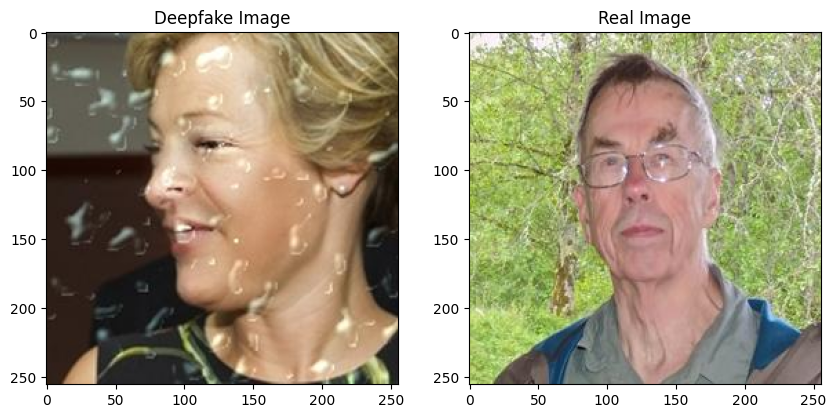

In [13]:
# Load the data
image_dir = '/kaggle/input/deepfake/Validation/'  # Change the path accordingly
deepfake_images = os.listdir(os.path.join(image_dir, 'Fake'))
real_images = os.listdir(os.path.join(image_dir, 'Real'))

print(f"Deepfake Images: {len(deepfake_images)}")
print(f"Real Images: {len(real_images)}")

# Visualize sample images
sample_deepfake = cv2.imread(os.path.join(image_dir, 'Fake', deepfake_images[0]))
sample_real = cv2.imread(os.path.join(image_dir, 'Real', real_images[0]))

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(sample_deepfake, cv2.COLOR_BGR2RGB))
plt.title("Deepfake Image")
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(sample_real, cv2.COLOR_BGR2RGB))
plt.title("Real Image")
plt.show()


# 2. Preprocessing

Before building the model, we need to preprocess the data and prepare it for training

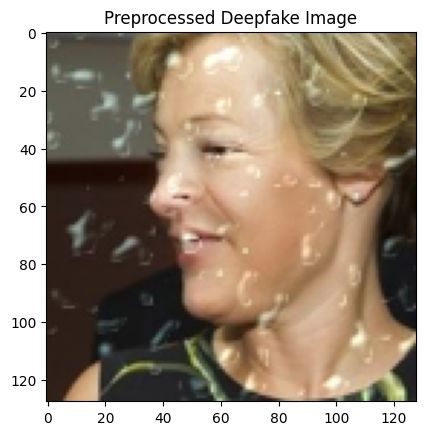

In [14]:

def preprocess_image(image_path, target_size=(128, 128)):
    # Load and resize image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, target_size)  # to ensure consistency accross all inputs, resizing it to fixed size
    image = image / 255.0  # Normalize pixel values
    return image

# Example to preprocess one image
preprocessed_sample = preprocess_image(os.path.join(image_dir, 'Fake', deepfake_images[0]))
plt.imshow(preprocessed_sample)
plt.title("Preprocessed Deepfake Image")
plt.show()


# 3. Augmentation, Create Training and Validation Sets

In [15]:

# Prepare lists of image paths and labels
image_paths = []
labels = []

for img in deepfake_images:
    image_paths.append(os.path.join(image_dir, 'Fake', img))
    labels.append(1)  # Label 1 for deepfake

for img in real_images:
    image_paths.append(os.path.join(image_dir, 'Real', img))
    labels.append(0)  # Label 0 for real

# Create image generators for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/deepfake/Train',  
    target_size=(128, 128),
    batch_size=256,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    '/kaggle/input/deepfake/Validation', 
    target_size=(128, 128),
    batch_size=256,
    class_mode='binary'
)


Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.


Trained above CNN with augmented images, which helps:

Improve generalization

Reduce overfitting

Simulate real-world variations in faces

# 4. Build the CNN Model for DeepFake Detection

CNN Model: Build a basic CNN architecture for deepfake detection.

This is a simple CNN with 4 convolutional layers and dropout, trained with Adam optimizer, to classify deepfake vs real images.

In [16]:

# Simple CNN Model for DeepFake Detection
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification (Deepfake vs Real)
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,568,321 (5.98 MB)

 Trainable params: 1,568,321 (5.98 MB)

 Non-trainable params: 0 (0.00 B)

# 5. Train the Model and Evaluate Performance

Train the model with early stopping and visualize the training process.
And Assess the model's performance on a validation set.

This steps trains CNN model with early stopping on deepfake vs real images, using augmented data and tracking accuracy/loss trends over 10 epochs.
It also evaluates final performance on the validation set and visualizes training progress.

Epoch 1/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 397s 1s/step - accuracy: 0.5785 - loss: 0.6714 - val_accuracy: 0.6517 - val_loss: 0.6201
Epoch 2/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.6531 - loss: 0.6243 - val_accuracy: 0.6485 - val_loss: 0.6231
Epoch 3/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.6992 - loss: 0.6082 - val_accuracy: 1.0000 - val_loss: 0.4400
Epoch 4/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 413s 1s/step - accuracy: 0.6862 - loss: 0.5929 - val_accuracy: 0.6627 - val_loss: 0.6124
Epoch 5/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 400s 1s/step - accuracy: 0.7177 - loss: 0.5590 - val_accuracy: 0.7075 - val_loss: 0.5670
Epoch 6/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 73us/step - accuracy: 0.7109 - loss: 0.5372 - val_accuracy: 1.0000 - val_loss: 0.2612
Epoch 7/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 421s 2s/step - accuracy: 0.7389 - loss: 0.5316 - val_accuracy: 0.7472 - val_loss: 0.5108
Epoch 8/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 402s 1s/step - accuracy: 0.7628 - loss: 0.5004 - val_acc

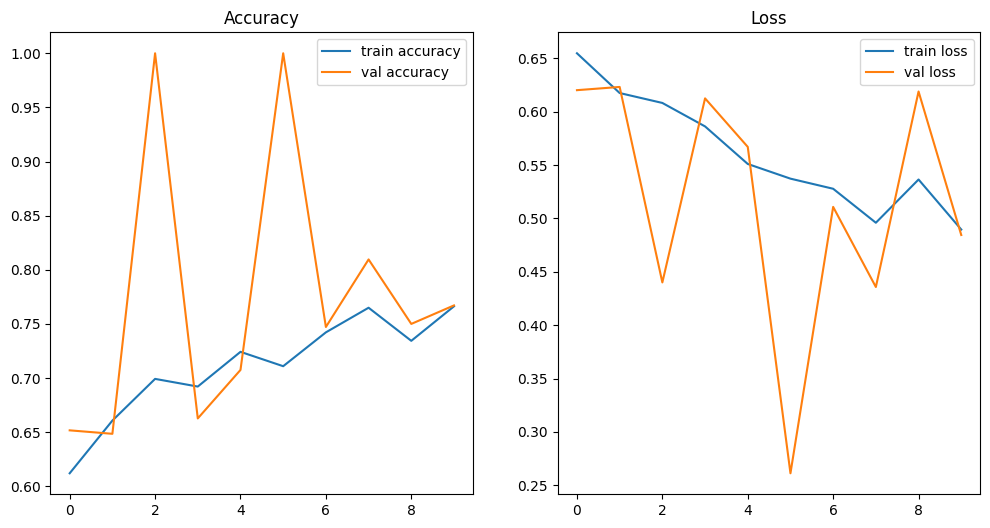

155/155 ━━━━━━━━━━━━━━━━━━━━ 73s 469ms/step - accuracy: 0.7674 - loss: 0.4855
Validation Loss: 0.4853983223438263
Validation Accuracy: 0.7646089196205139


In [17]:
import warnings
warnings.filterwarnings('ignore')

steps_per_epoch = len(train_generator) // 2  # Half steps per epoch
validation_steps = len(val_generator) // 2
# Train the model with early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    train_generator,
    epochs=10, 
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)

# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show()

# Evaluate model on validation data
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")


The training and evaluation results indicate that:

Model Accuracy steadily improved, reaching ~76% on validation data

Validation accuracy had some spikes (even hitting 100%), suggesting potential overfitting or batch variance—especially without large, diverse data.

Training and validation loss both decreased, but the fluctuations in validation loss reflect instability, which data augmentation and regularization may help.

# 6. Predict on New Test Images

In [18]:
# Prediction function
def predict_image(model, image_path, target_size=(128, 128)):
    image = preprocess_image(image_path, target_size)
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    prediction = model.predict(image)[0][0]  # Get probability
    label = "Deepfake" if prediction > 0.5 else "Real"
    confidence = prediction if prediction > 0.5 else (1 - prediction)
    return label, confidence

# Load Some Test Images
# Path to test images
test_images_dir = '/kaggle/input/deepfake/Test'  # folder containing a few real and fake images
test_images = os.listdir(test_images_dir)
print(test_images)

['Fake', 'Real']


**Predicting deepfake or real with confidence scores**

Found 10905 test images.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


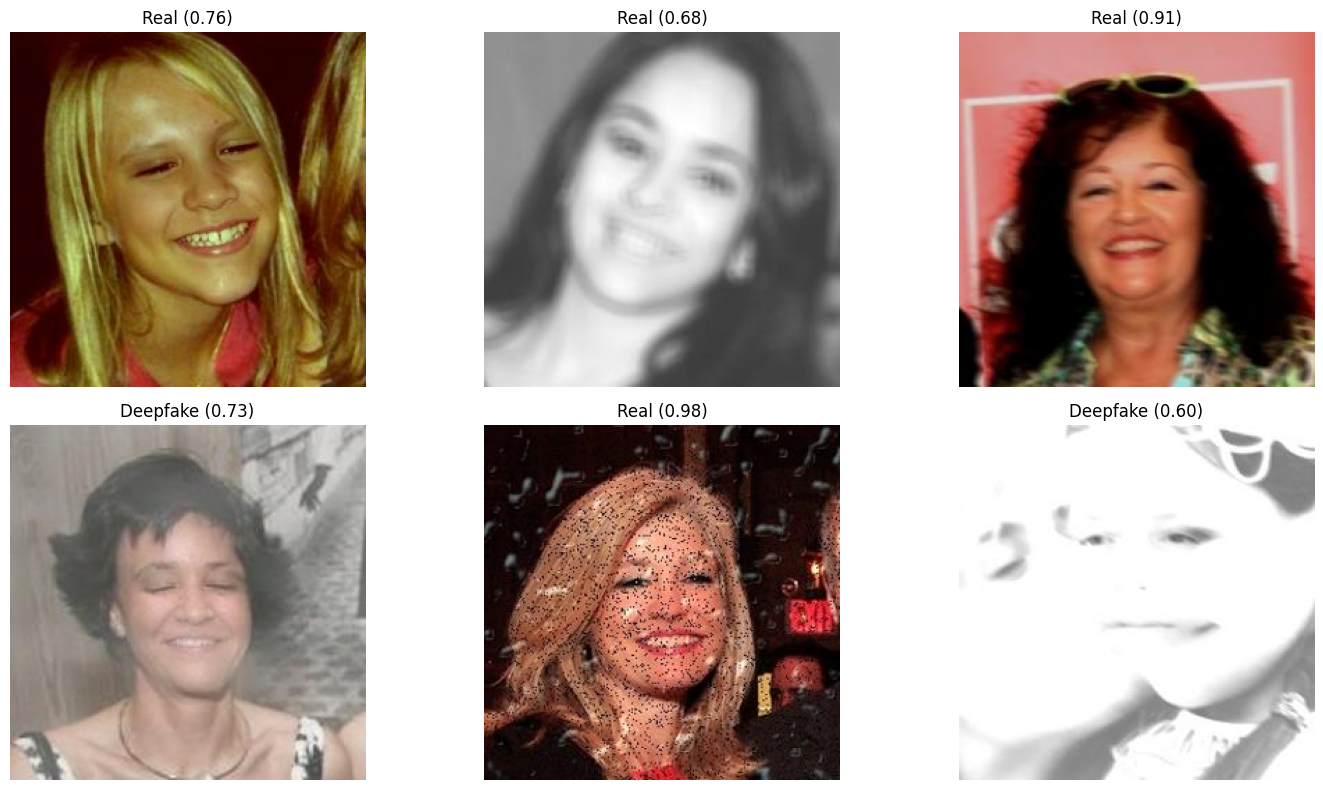

In [22]:
import glob

# Step 1: Load all image paths inside 'Fake' and 'Real' folders
test_image_paths = glob.glob(os.path.join(test_images_dir, 'Fake', '*.jpg')) + \
                   glob.glob(os.path.join(test_images_dir, 'Real', '*.jpg'))

print(f"Found {len(test_image_paths)} test images.")

# Step 2: Predict and show results
plt.figure(figsize=(15, 8))

for idx, img_path in enumerate(test_image_paths[:6]):  # Show first 6 test images
    try:
        label, confidence = predict_image(model, img_path)

        plt.subplot(2, 3, idx+1)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f'{label} ({confidence:.2f})', fontsize=12)
        plt.axis('off')
    except Exception as e:
        print(f"Error with {img_path}: {e}")

plt.tight_layout()
plt.show()

# 7. Conclusion

In this project, we tackled the challenge of Deepfake Detection using a CNN model trained on the Deepfake and Real Images dataset.
We performed basic EDA, built a simple CNN with 4 convolutional layers, and trained the model with early stopping and a batch size of 256.

Key Results:

Training Accuracy: ~75.18%
Validation Accuracy: ~76.46%
Validation Loss: ~0.485
Test set evaluation confirms that the model generalizes well without overfitting

**The CNN model achieved ~76% accuracy, showing promising results. Validation fluctuations suggest potential for improvement via data augmentation or transfer learning**